In [16]:
import numpy as np
import sympy as smp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

<div style="text-align: center;">
    <img src="Pendulo.png" alt="Pendulum Image">
</div>

Para estudiar este problema consideramos que las oscilaciones de nuestro sistema se acercan a la posición de equilibrio relativo. Por lo tanto, podemos suponer: $$J_1 = J_2$$

Por lo tanto, para el estado de equilibrio relativo los ángulos $\varphi_{10}$ y $\varphi_{20}$ son iguales, y entonces podemos escribir: $$\rho = b + \xi (t)$$ $$\varphi_1 = \varphi_0 + \varphi (t)$$ $$\varphi_2 = \varphi_0 + \psi (t)$$

Se definen los parametros y funciones a utilizar:
- $m$: Masa del disco
- $\omega$: Frecuencia de oscilación de $O_1$
- $h$: Amplitud de la osiclación de $O_1$
- $l$: Longitud natural del resorte
- $k$: Constante de elasticidad del resorte
- $J_3$: Momento de inercia del disco respecto al eje $\zeta$
- $a$: Radio del disco
- $b$: Longitud de la cuerda del péndulo en el caso de equilibrio relativo
- $\varphi_0$: Angulo de inclinación en el caso de equilibrio relativo
- $\xi (t)$, $\varphi (t)$, $\psi (t)$: Coordenadas generalizadas que representan pequeñas desviaciones del equilibrio



In [17]:
m,w,l,J_3,a,b,g,h,phi_0, k, t = smp.symbols(r'm \omega l J_3 a b g h \varphi_0 k t')

In [18]:
chi , phi, psi = smp.symbols(r'\xi \varphi \psi ', cls=smp.Function)

In [19]:
#chi
chi = chi(t)
chi_d = smp.diff(chi, t)
chi_dd = smp.diff(chi_d, t)

#psi
psi = psi(t)
psi_d = smp.diff(psi, t)
psi_dd = smp.diff(psi_d, t)

#phi
phi = phi(t)
phi_d = smp.diff(phi, t)
phi_dd = smp.diff(phi_d, t)

Se definen parametros auxiliares adicionales:

In [20]:
l_1 = (a**2 - (J_3/m))/a
K2 = (k**2)/m

a11 = K2 - w**2 *(smp.sin(phi_0)**2 + 2*h*smp.cos(phi_0)*smp.sin(w*t))
b12 = K2*(b-l) - w**2 *b*smp.cos(phi_0)**2
b13 = - w**2 *a*smp.cos(phi_0)**2
c11 = -(w**2 * smp.sin(phi_0) * smp.cos(phi_0))
c12 = -( w**2 * b * (smp.cos(phi_0))**2)
c13 = (K2*(b-l)) + (2*h*smp.sin(phi_0)*smp.sin(w*t) - a*(smp.cos(phi_0))**2)*w**2
a12 = b*c11
a13 = a*c11
b11 = c11  
f3 = chi_dd*(psi-phi)+(b*phi_d**2+chi*phi_d**2)*(phi-psi)-chi*phi_dd - 2*chi_d*phi_d + 2*w**2 *h*smp.sin(w*t)*smp.cos(phi_0)-c11*(b+a*(1-psi**2)-psi*phi*(b+chi))-g*smp.sin(phi_0) + w**2 *chi*(phi*(smp.cos(phi_0)**2)-psi*(smp.sin(phi_0)**2))

A = -2*c11
B = a*(w**2)*(smp.cos(phi_0)**2)
D = (w**2)*smp.cos(2*phi_0)
C1 = -b*(K2-w**2*smp.sin(phi_0)**2)+w**2*(2*h*smp.sin(phi_0)*smp.sin(w*t)+a*(smp.sin(w*t)**2+smp.sin(phi_0)**2))+g*smp.cos(phi_0)+K2*l
C2 = 2*h*w**2*smp.sin(w*t)-(b+a)*c11-g*smp.sin(phi_0)
H = a*b*(psi**2-phi*psi-1)+l_1*(b+chi)


In [21]:
H

a*b*(\psi(t)**2 - \psi(t)*\varphi(t) - 1) + (b + \xi(t))*(-J_3/m + a**2)/a

Se obtienen las ecuaciones de movimiento asociadas a cada coordenada:

In [22]:
eq_chidd = smp.Eq(chi_dd, -(1/H)*(-a*psi*(-(b+chi)*(c11*chi+c12*phi+c13*psi-f3)+b*(b11*chi+b12*phi+b13*psi+g*smp.sin(phi_0)+w**2*(-chi*phi*smp.cos(phi_0)**2-2*h*smp.sin(w*t)*smp.cos(phi_0)+smp.cos(phi_0)*smp.sin(phi_0)*(-b+phi*psi*(b+chi)+a*(psi**2-1))+chi*phi*smp.sin(phi_0)**2)+2*chi_d*phi_d-phi_d**2*(b+chi)*(phi-psi)))+(a*b-l_1*(b+chi))*(C1-a11*chi-a12*phi-a13*psi+phi_d**2*(b+chi)+phi*(A*chi+B*psi+a*psi_d**2))))
eq_phidd = smp.Eq(phi_dd, -f3/b - c11*chi - c12*phi - c13*psi + (l_1/(a*psi))*(C1-a11*chi-a12*phi-a13*psi + (b+chi)*phi_d**2 + (A*chi+B*psi+a*psi_d**2)*phi) + (1/(a*H*psi))*(l_1*(-a*psi*((b+chi)*(f3-c11*chi-c12*phi-c13*psi)+b*(b11*chi+b12*phi+b13*psi+g*smp.sin(phi_0)+w**2 *(-chi*phi*smp.cos(phi_0)**2 - 2*h*smp.sin(w*t)*smp.cos(phi_0)+((b+chi)*phi*psi+a*(psi**2 -1)-b)*smp.cos(phi_0)*smp.sin(phi_0) + chi*phi*smp.sin(phi_0)**2) + 2*chi_d*phi_d - (b+chi)*(phi-psi)*phi_d**2)) + (a*b - (b+chi)*l_1)*(C1-a11*chi-a12*phi-a13*psi + (b+chi)*phi_d**2 + (A*chi+B*psi+a*psi_d**2)*phi))))
eq_psidd = smp.Eq(psi_dd, -(1/H)*(b*(phi-psi)*(a11*chi+a12*phi+a13*psi-(A*chi+B*psi)*phi) - b*(b11*chi+b12*phi+b13*psi) + (b+chi)*(c11*chi+c12*phi+c13*psi) - b*C1*(phi-psi) + b*w**2 *smp.cos(phi_0)*(chi*phi*smp.cos(phi_0)+2*h*smp.sin(w*t)) - (b+chi)*f3 - b*g*smp.sin(phi_0) + b*w**2 *(a+b-psi*((b+chi)*phi+a*psi))*smp.cos(phi_0)*smp.sin(phi_0) - b*(2*chi_d*phi_d + phi*(w**2 *chi*smp.sin(phi_0)**2 + a*(phi-psi)*psi_d**2))))
# Corrigiendo missspellings en las ecuaciones

In [23]:
eq_psidd

Eq(Derivative(\psi(t), (t, 2)), -(\omega**2*b*(2*h*sin(\omega*t) + \varphi(t)*\xi(t)*cos(\varphi_0))*cos(\varphi_0) + \omega**2*b*(a + b - (a*\psi(t) + (b + \xi(t))*\varphi(t))*\psi(t))*sin(\varphi_0)*cos(\varphi_0) - b*g*sin(\varphi_0) - b*((\omega**2*\xi(t)*sin(\varphi_0)**2 + a*(-\psi(t) + \varphi(t))*Derivative(\psi(t), t)**2)*\varphi(t) + 2*Derivative(\varphi(t), t)*Derivative(\xi(t), t)) - b*(-\psi(t) + \varphi(t))*(\omega**2*(a*(sin(\varphi_0)**2 + sin(\omega*t)**2) + 2*h*sin(\varphi_0)*sin(\omega*t)) - b*(-\omega**2*sin(\varphi_0)**2 + k**2/m) + g*cos(\varphi_0) + k**2*l/m) + b*(-\psi(t) + \varphi(t))*(-\omega**2*a*\psi(t)*sin(\varphi_0)*cos(\varphi_0) - \omega**2*b*\varphi(t)*sin(\varphi_0)*cos(\varphi_0) + (-\omega**2*(2*h*sin(\omega*t)*cos(\varphi_0) + sin(\varphi_0)**2) + k**2/m)*\xi(t) - (\omega**2*a*\psi(t)*cos(\varphi_0)**2 + 2*\omega**2*\xi(t)*sin(\varphi_0)*cos(\varphi_0))*\varphi(t)) - b*(-\omega**2*a*\psi(t)*cos(\varphi_0)**2 - \omega**2*\xi(t)*sin(\varphi_0)*cos(\va

Se procede a despejar las segundas derivadas individualmente:

In [24]:
sols = smp.solve([eq_chidd, eq_phidd, eq_psidd], (chi_dd, phi_dd, psi_dd), simplify = True, rational= False)

In [30]:
sols[chi_dd]

(J_3*\omega**2*a*b**2*m*\psi(t)*\varphi(t)*\xi(t)*cos(2*\varphi_0)/2 + J_3*\omega**2*a*b**2*m*\psi(t)*\varphi(t)*\xi(t)/2 - J_3*\omega**2*a*b**2*m*\psi(t)*\varphi(t)*cos(2*\varphi_0)/2 - J_3*\omega**2*a*b**2*m*\psi(t)*\varphi(t)/2 + J_3*\omega**2*a*b**2*m*\psi(t)*\xi(t)*sin(2*\varphi_0)/2 - J_3*\omega**2*a*b**2*m*\psi(t)*sin(2*\varphi_0)/2 - J_3*\omega**2*a*b**2*m*\xi(t)*cos(2*\varphi_0)/2 - J_3*\omega**2*a*b**2*m*\xi(t)*cos(2*\omega*t)/2 + J_3*\omega**2*a*b**2*m*\xi(t) + J_3*\omega**2*a*b**2*m*cos(2*\varphi_0)/2 + J_3*\omega**2*a*b**2*m*cos(2*\omega*t)/2 - J_3*\omega**2*a*b**2*m + J_3*\omega**2*a*b*m*\psi(t)*\varphi(t)*\xi(t)**2*cos(2*\varphi_0)/2 + J_3*\omega**2*a*b*m*\psi(t)*\varphi(t)*\xi(t)**2/2 + J_3*\omega**2*a*b*m*\psi(t)*\xi(t)**2*sin(2*\varphi_0)/2 - J_3*\omega**2*a*b*m*\xi(t)**2*cos(2*\varphi_0)/2 - J_3*\omega**2*a*b*m*\xi(t)**2*cos(2*\omega*t)/2 + J_3*\omega**2*a*b*m*\xi(t)**2 + J_3*\omega**2*a*m*\psi(t)*\varphi(t)*\xi(t)**2*cos(2*\varphi_0)/2 + J_3*\omega**2*a*m*\psi(t)*\v

Se convierten a expresiones numéricas con el fin de poder utilizar métodos númericos para resolverlas. Dividiendo el sistema de 3 ecuaciones de segundo orden en 6 ecuaciones de primer orden, de modo que:
- $d\xi/dt = v_1$
- $dv_1/dt = \dots$
- $d\varphi/dt = v_2$
- $dv_2/dt = \dots$
- $d\psi/dt = v_3$
- $dv_3/dt = \dots$

In [25]:
dchidt_f = smp.lambdify(chi_d, chi_d, modules=['numpy']) 
dv1dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[chi_dd], modules=['numpy'])

dphidt_f = smp.lambdify(phi_d, phi_d, modules=['numpy']) 
dv2dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[phi_dd], modules=['numpy'])

dpsidt_f = smp.lambdify(psi_d, psi_d, modules=['numpy']) 
dv3dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[psi_dd], modules=['numpy'])

Se define $\vec{S} = (\xi, v_1, \varphi, v_2, \psi, v_3)$, de modo que el sistema que se busca solucionar es ahora de la forma: $$\frac{d \vec{S}}{dt} = f(t, \vec{S})$$

In [ ]:
def dSdt(t, S):
    chi, v1, phi, v2, psi, v3 = S
    return [
    dchidt_f(v1),
    dv1dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t),
    dphidt_f(v2),
    dv2dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t),
    dpsidt_f(v3),
    dv3dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t)
    ]
    

In [ ]:
t = np.linspace(0, 102, 1_000_000)
m = 50
w = 4
l = 0.7
J_3 = 8
a = 0.5
b = 3
g = 9.8
h = 2.4
phi_0 = 0
k = np.power(w, 2)*m

# Iniciales xi, xi', phi, phi', psi, psi'
y0 = [0.001, 0, 0.1, 0, 0.01, 0]

#Problemas con el metodo RK45 o el solver en general, revisar ecuaciones y condiciones iniciales, pues dan derivadas muy grandes
ans = solve_ivp(dSdt, (t[0], t[-1]), y0, method='Radau', t_eval=t) #, atol=1e-6, rtol=1e-6, max_step=0.001


In [55]:
xi = ans.y[0]
xi_d = ans.y[1]
phi = ans.y[2]
phi_d = ans.y[3]
psi = ans.y[4]
psi_d = ans.y[5]
 

In [56]:
print(xi)
print(ans.message)
print(dSdt(0, y0)) # Valor de las derivadas es muy grande
print(t[0], t[-1])
print(ans.t[-1])
 

[ 1.00000000e-03  8.46626857e-04  3.86514735e-04 -3.80252336e-04
 -1.45356822e-03 -2.83328534e-03 -4.51918425e-03 -6.51102021e-03
 -8.80852206e-03 -1.14113218e-02 -1.43190360e-02 -1.75312598e-02
 -2.10475025e-02 -2.48672264e-02 -2.89898718e-02 -3.34148433e-02
 -3.81414462e-02 -4.31689686e-02 -4.84966763e-02 -5.41237480e-02
 -6.00493076e-02 -6.62724566e-02 -7.27922606e-02 -7.96076759e-02
 -8.67176385e-02 -9.41210604e-02 -1.01816762e-01 -1.09803495e-01
 -1.18079991e-01 -1.26644940e-01 -1.35496908e-01 -1.44634426e-01
 -1.54056016e-01 -1.63760116e-01 -1.73745017e-01 -1.84009008e-01
 -1.94550313e-01 -2.05367166e-01 -2.16457565e-01 -2.27819483e-01
 -2.39450852e-01 -2.51349596e-01 -2.63513453e-01 -2.75940027e-01
 -2.88626924e-01 -3.01571640e-01 -3.14771687e-01 -3.28224249e-01
 -3.41926504e-01 -3.55875555e-01 -3.70068518e-01 -3.84502182e-01
 -3.99173218e-01 -4.14078291e-01 -4.29213954e-01 -4.44576538e-01
 -4.60162232e-01 -4.75967163e-01 -4.91987231e-01 -5.08218165e-01
 -5.24655624e-01 -5.41294

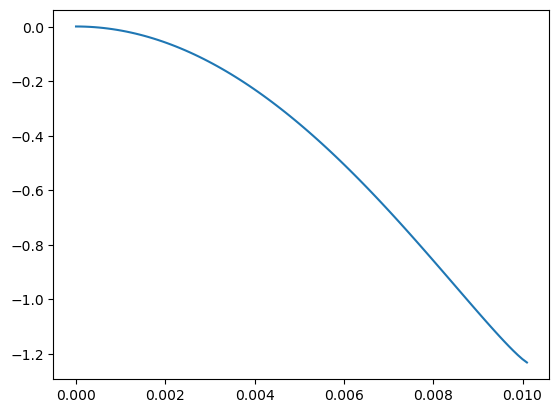

In [57]:
plt.plot(ans.t, xi)